In [1]:
import numpy as np
import pandas as pd
import anndata as ad
import scanpy as sc
import matplotlib.pyplot as plt
import os
import seaborn as sb
import sys
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
sc.settings.verbosity = 3      
import inspect
import torch

In [2]:
sys.path.append('/Users/shrey.parikh/Desktop/Test_2/Untitled/')
from cross_system_integration.model._xxjointmodel import XXJointModel


Global seed set to 0


In [3]:
# Set random seed for reproducibility
np.random.seed(42)

# Number of cells per organism
num_cells_organism1 = 100
num_cells_organism2 = 150
num_cells_organism3 = 120

# Number of genes
num_genes = 500

# Generate gene expression data for each organism from different distributions
data_organism1 = np.random.normal(loc=0, scale=1, size=(num_cells_organism1, num_genes))
data_organism2 = np.random.normal(loc=5, scale=1, size=(num_cells_organism2, num_genes))
data_organism3 = np.random.normal(loc=-3, scale=1, size=(num_cells_organism3, num_genes))
# Create batch labels
batch_labels_organism1 = np.zeros(num_cells_organism1)
batch_labels_organism2 = np.ones(num_cells_organism2) * 1
batch_labels_organism3 = np.ones(num_cells_organism3) * 2

# Concatenate data and batch labels
data = np.concatenate([data_organism1, data_organism2, data_organism3])
batch_labels = np.concatenate([batch_labels_organism1, batch_labels_organism2, batch_labels_organism3])

# Create AnnData object
adata = ad.AnnData(X=data, obs={'organism': batch_labels})
adata.obs.organism = adata.obs.organism.map({0.0:'Org_A', 1.0:'Org_B', 2.0:'Org_C'}).astype('category')

# Generate random batch labels for each set of keys
batch_labels_dict = {}

# Keys 0 to 99 (batch 1 or batch 2)
keys_batch1_2 = np.arange(0, 100)
batch_labels_dict.update(dict(zip(keys_batch1_2, np.random.choice(['batch 1', 'batch 2'], size=num_cells_organism1))))

# Keys 100 to 149 (batch 3 or batch 4)
keys_batch3_4 = np.arange(100, 250)
batch_labels_dict.update(dict(zip(keys_batch3_4, np.random.choice(['batch 3', 'batch 4'], size=num_cells_organism2))))

# Keys 150 to 369 (batch 5 or batch 6)
keys_batch5_6 = np.arange(250, 370)
batch_labels_dict.update(dict(zip(keys_batch5_6, np.random.choice(['batch 5', 'batch 6'], size=num_cells_organism3))))
adata.obs.index = adata.obs.index.astype(int)

# Print the generated dictionary
adata.obs['batch'] = 'default_batch'  
adata.obs['batch'].update(batch_labels_dict)

computing PCA
    with n_comps=50
    finished (0:00:21)
computing neighbors
    using 'X_pca' with n_pcs = 20
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:00)


/Users/shrey.parikh/mambaforge/envs/cross_species/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/Users/shrey.parikh/mambaforge/envs/cross_species/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/shrey.parikh/mambaforge/envs/cross_species/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categor

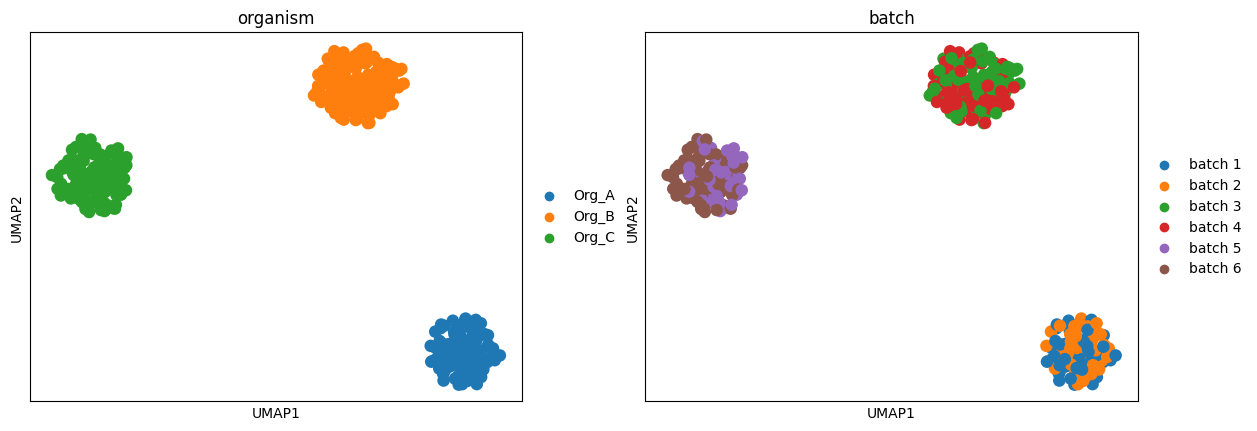

In [4]:
# # Compute PCA
sc.pp.pca(adata)

# # Compute UMAP
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=20)
sc.tl.umap(adata)
# # Plot UMAP
sc.pl.umap(adata, color=['organism', 'batch'])

In [4]:
adata_training = XXJointModel.setup_anndata(
    adata=adata,
    system_key='organism',
    group_key=None,
    categorical_covariate_keys=['batch'],
)

INFO     Using column names from columns of adata.obsm['covariates']                                               
INFO     Using column names from columns of adata.obsm['system']                                                   


In [5]:
model = XXJointModel(
    adata=adata_training,
    out_var_mode='feature',
    # mixup_alpha=None,
    # system_decoders=False,
    prior='vamp',
    n_prior_components=5,
    pseudoinputs_data_init=True,
    z_dist_metric = 'MSE_standard',
    n_layers=2,
    n_hidden=256)

<frozen abc>:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.



In [6]:
import pytorch_lightning as pl
model.train(
    max_epochs=5,
    log_every_n_steps=1,
    check_val_every_n_epoch=1,
    val_check_interval=1.0,
    train_size=0.9,
    plan_kwargs={
        'optimizer': "Adam",
        'lr': 0.001,
        'reduce_lr_on_plateau': False,
        'lr_scheduler_metric': 'loss_train',  # Replace with default value
        'lr_patience': 5,  # Replace with default value
        'lr_factor': 0.1,  # Replace with default value
        'lr_min': 1e-7,  # Replace with default value
        'lr_threshold_mode': 'rel',  # Replace with default value
        'lr_threshold': 0.1,  # Replace with default value
        'log_on_epoch': True,  # Replace with default value
        'log_on_step': False,  # Replace with default value
        'loss_weights': {
            'kl_weight': 1.0,  # Replace with default value  # Replace with default value
            'reconstruction_weight': 1.0,  # Replace with default value
            'z_distance_cycle_weight': 5.0, 
        },
    }
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..


Epoch 1/5:   0%|          | 0/5 [00:00<?, ?it/s]tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [0., 0., 1.],
        [1., 0., 0.],
        [0., 0., 1.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [1., 0., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 0.],
        [0., 0., 1.],
        [1., 0., 0.],
        [0., 0., 1.],
        [1., 0., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [0., 0., 1.],
        [1., 0., 0.],
        [0., 0., 1.],
        [1., 0., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [1., 0., 0.],
      

In [7]:
embed = model.embed(
    adata=adata_training,
    indices=None,
    batch_size=None,
    as_numpy=True)
embed=sc.AnnData(embed,obs=adata_training.obs)
# Make system categorical for eval as below
embed.obs['organism']=embed.obs['organism'].astype(str)

In [ ]:
sc.pp.neighbors(embed, use_rep='X')
sc.tl.umap(embed)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)


computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:00)


/Users/shrey.parikh/mambaforge/envs/cross_species/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/Users/shrey.parikh/mambaforge/envs/cross_species/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/shrey.parikh/mambaforge/envs/cross_species/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categor

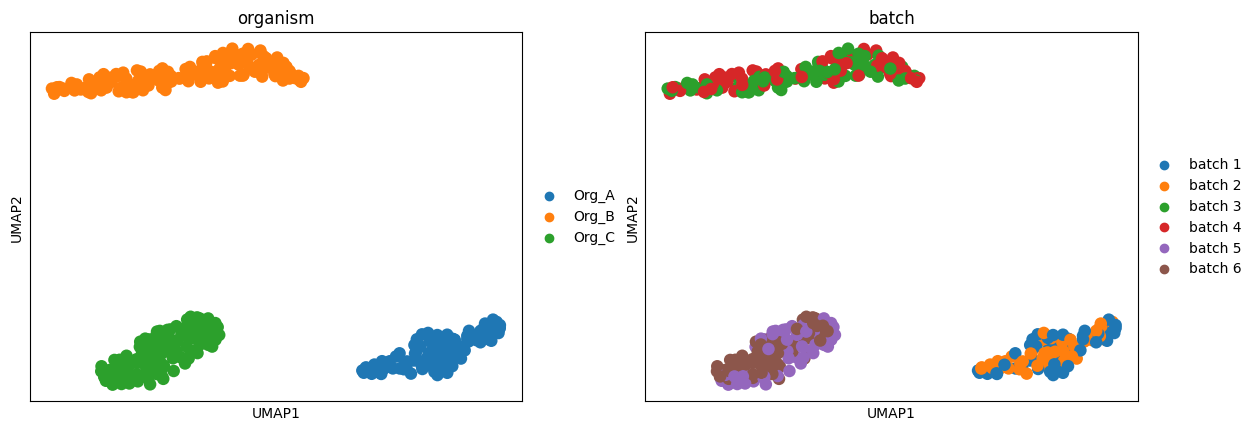

In [ ]:
sc.pl.umap(embed, color=['organism', 'batch'])